In [1]:
%matplotlib inline

import pandas as pd 
import numpy as np
import itertools

import tokenize_uk
from stop_words import get_stop_words

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from sklearn.utils import resample

from common import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_json('reviews.json')

In [3]:
for n, g in df.groupby(['stars']):
    print('Class:', n, 'length:', len(g))

Class: 1 length: 2305
Class: 2 length: 2304
Class: 3 length: 4676
Class: 4 length: 15051
Class: 5 length: 42405


#### Preprocessing data 
- join paragraphs
- lowercase everything 

In [4]:
df['text'] = df['text'].apply(lambda x: ' '.join(x).lower())

In [5]:
df.head(20)

,stars,text
0,5,компьютерная марка lenovo известна своими дост...
1,5,вопрос к представителю:. можно ли надеяться на...
2,5,очень хорошая рабочая шустрая лошадка с приятн...
3,5,сбалансированные характеристики у планшета. дл...
4,5,"чудовий планшет, дружина використовує завжди з..."
5,4,користуюсь більше місяця. звичайно є недоліки...
6,3,планшет покупался для работы с текстами в доро...
7,5,майнкрафт на минимальных настройках графики по...
8,5,adobe p и adobe i как пойдут?
9,3,існують питання до якості картриджа недостатки...


#### Partitioning data into train/validation
Train is later used for cross-validation 

In [6]:
X, y = df['text'].values, df['stars'].values

partitioner = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
indexes = partitioner.split(X, y)
train_indexes, val_indexes = list(indexes)[0]

X, X_val, y, y_val = X[train_indexes], X[val_indexes], y[train_indexes], y[val_indexes]

for cls in np.sort(np.unique(y)):
    print('Train Class {}: {} examples'.format(cls, len(y[y == cls])))
    print('Validation Class {}: {} examples'.format(cls, len(y_val[y_val == cls])))
    
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1234)

Train Class 1: 1844 examples
Validation Class 1: 461 examples
Train Class 2: 1843 examples
Validation Class 2: 461 examples
Train Class 3: 3741 examples
Validation Class 3: 935 examples
Train Class 4: 12041 examples
Validation Class 4: 3010 examples
Train Class 5: 33923 examples
Validation Class 5: 8482 examples


#### Creating learning pipeline with RandomForestClassifier and BOW without any text preprocessing

In [7]:
cv_f1_scores = []
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    
    vectorizer = CountVectorizer(analyzer='word',
                                 ngram_range=(1, 2),
                                 max_df=1.0, min_df=0.01,
                                 tokenizer=tokenize_uk.tokenize_words,
                                 stop_words=None)
    clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
    pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_train)
    print('Train score: ', f1_score(y_train, y_pred, average='weighted'))
    
    y_pred = pipeline.predict(X_test)
    cv_f1_scores.append(f1_score(y_test, y_pred, average='weighted')) 

print('Test CV score:', sum(cv_f1_scores) / float(len(cv_f1_scores)))

vectorizer = CountVectorizer(analyzer='word',
                                 ngram_range=(1, 2),
                                 max_df=1.0, min_df=0.01,
                                 tokenizer=tokenize_uk.tokenize_words,
                                 stop_words=None)
clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])

pipeline.fit(X, y)
y_pred = pipeline.predict(X_val)
print('Validation score:', f1_score(y_val, y_pred, average='weighted'))

Train score:  0.9865255761471166
Train score:  0.9849750139532987
Train score:  0.9866378780855968
Test CV score: 0.5754195395370764
Validation score: 0.5756204911398394


#### Confusion matrix for RF with BOW

[[  34   12   26   96  293]
 [  22   19   46  148  226]
 [  15   17   65  333  505]
 [  17   25   90  807 2071]
 [  20   19   91  985 7367]]


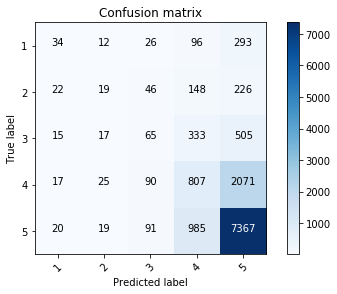

In [8]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

In [9]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.31      0.07      0.12       461
          2       0.21      0.04      0.07       461
          3       0.20      0.07      0.10       935
          4       0.34      0.27      0.30      3010
          5       0.70      0.87      0.78      8482

avg / total       0.56      0.62      0.58     13349



As we can see from above reports, due to imbalanced classes (42k in 5th class vs 2k in 1th and 2nd classes), 
majority class is predicted with f1_score = 0.78, whereas f1_score for 1st and 2nd classes eq 0.11 and 0.08 respectively.

#### Creating learning pipeline with RandomForestClassifier and TF-IDF without any text preprocessing

In [10]:
cv_f1_scores = []
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    
    vectorizer = TfidfVectorizer()
    clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
    pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_train)
    print('Train score: ', f1_score(y_train, y_pred, average='weighted'))
    
    y_pred = pipeline.predict(X_test)
    cv_f1_scores.append(f1_score(y_test, y_pred, average='weighted')) 

print('Test CV score:', sum(cv_f1_scores) / float(len(cv_f1_scores)))

vectorizer = TfidfVectorizer()
clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])

pipeline.fit(X, y)
y_pred = pipeline.predict(X_val)
print('Validation score:', f1_score(y_val, y_pred, average='weighted'))

Train score:  0.9865157362833096
Train score:  0.9853836384268911
Train score:  0.9856353105799737
Test CV score: 0.5544339502715808
Validation score: 0.5585058836012323


[[  41   18   31   57  314]
 [  16   12   18   88  327]
 [  20   10   41  181  683]
 [   6    6   35  443 2520]
 [  11    8   23  461 7979]]


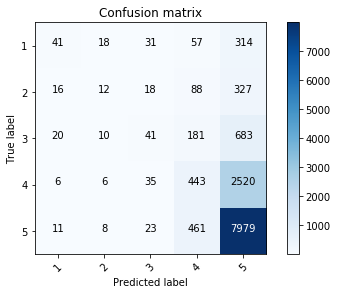

In [11]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

In [12]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.44      0.09      0.15       461
          2       0.22      0.03      0.05       461
          3       0.28      0.04      0.08       935
          4       0.36      0.15      0.21      3010
          5       0.67      0.94      0.79      8482

avg / total       0.55      0.64      0.56     13349



Similar situation with TF-IDF, so the problem is in fact that classes are imbalanced, not feature extraction method (for now)

### Resampling dataset to make it balanced

Min class is `1` and `2` so downlsampling other to their length

In [13]:
df_minority = df[df['stars'] == 1]
df_2 = df[df['stars'] == 2] # no downsampling here as it is small enough

df_3 = df[df['stars'] == 3]
df_4 = df[df['stars'] == 4]
df_5 = df[df['stars'] == 5]

df_3_downsampled = resample(df_3, replace=False, n_samples=len(df_minority), random_state=1234)
df_4_downsampled = resample(df_4, replace=False, n_samples=len(df_minority), random_state=1234)
df_5_downsampled = resample(df_5, replace=False, n_samples=len(df_minority), random_state=1234)

df_downsampled = pd.concat([df_minority, df_2, df_3_downsampled, df_4_downsampled, df_5_downsampled])

for n, g in df_downsampled.groupby(['stars']):
    print('Class:', n, 'length:', len(g))

Class: 1 length: 2305
Class: 2 length: 2304
Class: 3 length: 2305
Class: 4 length: 2305
Class: 5 length: 2305


In [14]:
X, y = df_downsampled['text'].values, df_downsampled['stars'].values

partitioner = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
indexes = partitioner.split(X, y)
train_indexes, val_indexes = list(indexes)[0]

X, X_val, y, y_val = X[train_indexes], X[val_indexes], y[train_indexes], y[val_indexes]

#### Creating RF + BOW pipeline on downsampled data

In [15]:
cv_f1_scores = []
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    
    vectorizer = CountVectorizer(analyzer='word',
                                 ngram_range=(1, 2),
                                 max_df=1.0, min_df=0.01,
                                 tokenizer=tokenize_uk.tokenize_words,
                                 stop_words=None)
    clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
    pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_train)
    print('Train score: ', f1_score(y_train, y_pred, average='weighted'))
    
    y_pred = pipeline.predict(X_test)
    cv_f1_scores.append(f1_score(y_test, y_pred, average='weighted')) 

print('Test CV score:', sum(cv_f1_scores) / float(len(cv_f1_scores)))

vectorizer = CountVectorizer(analyzer='word',
                                 ngram_range=(1, 2),
                                 max_df=1.0, min_df=0.01,
                                 tokenizer=tokenize_uk.tokenize_words,
                                 stop_words=None)
clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])

pipeline.fit(X, y)
y_pred = pipeline.predict(X_val)
print('Validation score:', f1_score(y_val, y_pred, average='weighted'))

Train score:  0.9887709248779784
Train score:  0.9864901438894391
Train score:  0.9863419081819595
Test CV score: 0.34889565217372764
Validation score: 0.3504519364726113


[[237 100  58  28  38]
 [147 128 100  51  35]
 [ 94 125 120  77  45]
 [ 44  65 111 125 116]
 [ 42  44  55 115 205]]


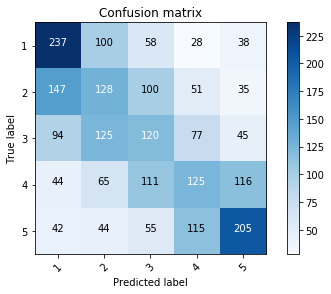

In [16]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

In [17]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.42      0.51      0.46       461
          2       0.28      0.28      0.28       461
          3       0.27      0.26      0.27       461
          4       0.32      0.27      0.29       461
          5       0.47      0.44      0.46       461

avg / total       0.35      0.35      0.35      2305



Overal validation score dropped drammatically to ~0.35
Although, from confusion matrix that classes 1, 2 (and a bit less 3) are confused between each other very often. 
From classification report we can see that f1_scores/precision/recall became a bit more equally distributed. 

#### RF + TF-IDF on balanced classes

In [18]:
cv_f1_scores = []
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    
    vectorizer = TfidfVectorizer()
    clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
    pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_train)
    print('Train score: ', f1_score(y_train, y_pred, average='weighted'))
    
    y_pred = pipeline.predict(X_test)
    cv_f1_scores.append(f1_score(y_test, y_pred, average='weighted')) 

print('Test CV score:', sum(cv_f1_scores) / float(len(cv_f1_scores)))

vectorizer = TfidfVectorizer()
clf = RandomForestClassifier(n_estimators=10, n_jobs=8)
pipeline = Pipeline([('vect', vectorizer), ('clf', clf)])

pipeline.fit(X, y)
y_pred = pipeline.predict(X_val)
print('Validation score:', f1_score(y_val, y_pred, average='weighted'))

Train score:  0.9876398350872867
Train score:  0.98877137833974
Train score:  0.9895898867191392
Test CV score: 0.3314253905907863
Validation score: 0.3230183747456971


[[225 113  50  42  31]
 [164 130  95  48  24]
 [110 132  99  78  42]
 [ 59  73 103 122 104]
 [ 45  55  63 124 174]]


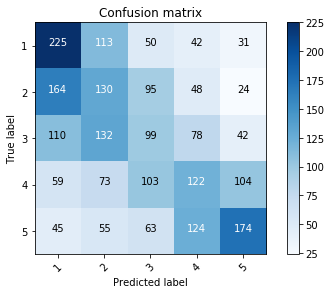

In [19]:
plot_confusion_matrix(confusion_matrix(y_val, y_pred), [1, 2, 3, 4, 5])

In [20]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          1       0.37      0.49      0.42       461
          2       0.26      0.28      0.27       461
          3       0.24      0.21      0.23       461
          4       0.29      0.26      0.28       461
          5       0.46      0.38      0.42       461

avg / total       0.33      0.33      0.32      2305



Same here. It is obvious now - we need better feature extraction method. First line attack with ignoring language, numbers, stopwords and other didn't work out. 

Further investigations are in separate notebook. 